Training Accuracy: 0.9933333333333333


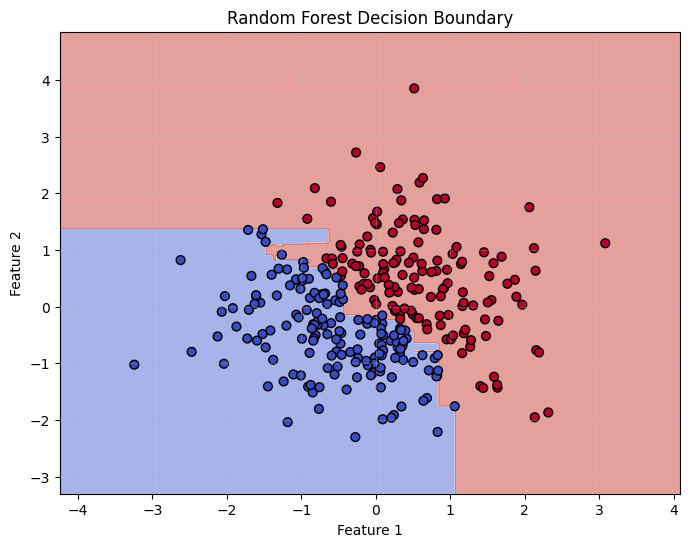

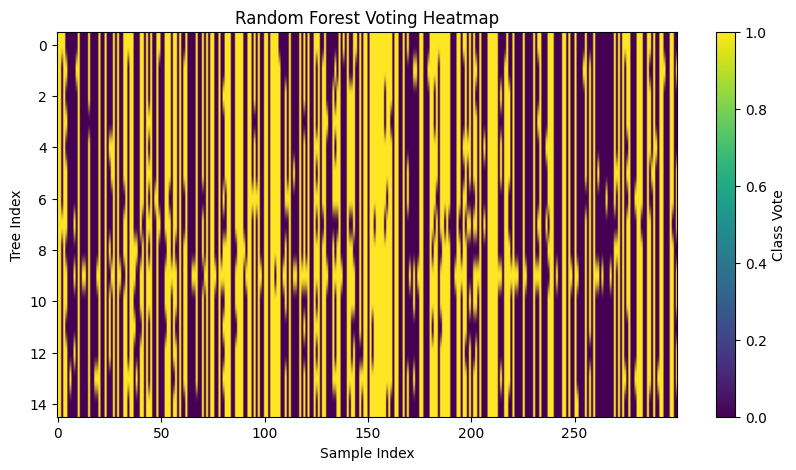

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# 1) Decision Tree Node

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value  # class label for leaf


# 2) Decision Tree

class DecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2, feature_subsample=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.feature_subsample = feature_subsample
        self.root = None

    def entropy(self, y):
        classes, counts = np.unique(y, return_counts=True)
        p = counts / len(y)
        return -np.sum(p * np.log2(p + 1e-9))

    def best_split(self, X, y, features):
        best_gain = -1
        split = {}

        current_entropy = self.entropy(y)

        for feat in features:
            thresholds = np.unique(X[:, feat])
            for t in thresholds:
                left_idx = X[:, feat] <= t
                right_idx = X[:, feat] > t

                if sum(left_idx) == 0 or sum(right_idx) == 0:
                    continue

                left_y, right_y = y[left_idx], y[right_idx]

                # weighted entropy
                w_entropy = (len(left_y)/len(y))*self.entropy(left_y) \
                            + (len(right_y)/len(y))*self.entropy(right_y)

                info_gain = current_entropy - w_entropy

                if info_gain > best_gain:
                    best_gain = info_gain
                    split = {
                        "feature": feat,
                        "threshold": t,
                        "left": (X[left_idx], y[left_idx]),
                        "right": (X[right_idx], y[right_idx])
                    }

        return split if best_gain > 0 else None

    def build(self, X, y, depth=0):
        if (len(y) < self.min_samples_split) or (depth >= self.max_depth):
            leaf_value = np.bincount(y).argmax()
            return Node(value=leaf_value)

        features = np.arange(X.shape[1])

        # feature subsampling
        if self.feature_subsample:
            features = np.random.choice(features, self.feature_subsample, replace=False)

        split = self.best_split(X, y, features)
        if split is None:
            leaf_value = np.bincount(y).argmax()
            return Node(value=leaf_value)

        left_node = self.build(split["left"][0], split["left"][1], depth+1)
        right_node = self.build(split["right"][0], split["right"][1], depth+1)

        return Node(feature=split["feature"],
                    threshold=split["threshold"],
                    left=left_node,
                    right=right_node)

    def fit(self, X, y):
        self.root = self.build(X, y)

    def predict_one(self, x):
        node = self.root
        while node.value is None:
            if x[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

    def predict(self, X):
        return np.array([self.predict_one(sample) for sample in X])



# 3) Random Forest (Bagging + Feature Subsampling)

class RandomForest:
    def __init__(self, n_trees=10, max_depth=5, sample_ratio=0.8):
        self.n_trees = n_trees
        self.trees = []
        self.max_depth = max_depth
        self.sample_ratio = sample_ratio

    def bootstrap(self, X, y):
        n_samples = int(len(X) * self.sample_ratio)
        idx = np.random.choice(len(X), n_samples, replace=True)
        return X[idx], y[idx]
    
    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(
                max_depth=self.max_depth,
                feature_subsample=int(np.sqrt(X.shape[1])) # √features
            )
            X_sample, y_sample = self.bootstrap(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # majority vote
        final_pred = np.apply_along_axis(lambda col: np.bincount(col).argmax(), 0, tree_preds)
        return final_pred

# 4) Generate Synthetic Data (2-class)
np.random.seed(42)
X = np.random.randn(300, 2)
y = (X[:, 0] + X[:, 1] > 0).astype(int)

# 5) Train the Random Forest
forest = RandomForest(n_trees=15, max_depth=5)
forest.fit(X, y)
preds = forest.predict(X)

print("Training Accuracy:", (preds == y).mean())

# Visualization 1 — Decision Boundary of Entire Forest

def plot_forest_boundary(model, X, y):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    Z = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.5)
    plt.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", s=40, edgecolors="k")
    plt.title("Random Forest Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(alpha=0.3)
    plt.show()

plot_forest_boundary(forest, X, y)


# Visualization 2 — Heatmap of Tree Votes

def plot_vote_heatmap(model, X):
    votes = np.zeros((model.n_trees, len(X)))
    for i, tree in enumerate(model.trees):
        votes[i] = tree.predict(X)

    plt.figure(figsize=(10,5))
    plt.imshow(votes, aspect="auto", cmap="viridis")
    plt.colorbar(label="Class Vote")
    plt.xlabel("Sample Index")
    plt.ylabel("Tree Index")
    plt.title("Random Forest Voting Heatmap")
    plt.show()

plot_vote_heatmap(forest, X)
